In [1]:
import numpy as np
import tensorflow_probability as tfp
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import matplotlib.pyplot as plt
import math
import os
import random
import string
import logging
import math
import cv2
import re 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import pathlib

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
# connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

D1024 12:59:13.500628600  271304 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1024 12:59:13.500652723  271304 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1024 12:59:13.500658404  271304 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1024 12:59:13.500680497  271304 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1024 12:59:13.500685028  271304 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1024 12:59:13.500689617  271304 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1024 12:59:13.500694151  271304 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1024 12:59:13.

In [2]:
images = []
file_names = []

for inx, file_name in enumerate(os.listdir('images')):

    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join('images', file_name)
        image = cv2.imread(image_path)[250:800, :550]  # crop
        image = cv2.resize(image, (256, 256))/255.
        # image = cv2.resize(image, (600, 600))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        file_names.append(file_name)

# blurry = []
# for ims in images:
#     gaussian = cv2.GaussianBlur(ims, (15, 15), 0)
#     blurry.append(gaussian)

In [3]:
def motion_blur_kernel(size, angle):

    kernel = np.zeros((size, size))
    cos_val = np.cos(np.deg2rad(angle))
    sin_val = np.sin(np.deg2rad(angle))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = j - center
            y = center - i
            if int(center + y * sin_val + x * cos_val) == center:
                kernel[i, j] = 1
    kernel /= np.sum(kernel)
    return kernel

def apply_blur(images, blur_degrees, motion_blur_sizes, motion_blur_angles):
    
    blur_degrees = blur_degrees + (blur_degrees % 2 == 0) # ensure the blur degree for each image is odd
    blurred_images = np.empty_like(images)

    for i, (image, blur_degree, size, angle) in enumerate(zip(images, blur_degrees, motion_blur_sizes, motion_blur_angles)):
        gaussian_blurred = cv2.GaussianBlur(image, (blur_degree, blur_degree), 0)
        kernel = motion_blur_kernel(size, angle)
        motion_blurred = cv2.filter2D(gaussian_blurred, -1, kernel)
        blurred_images[i] = motion_blurred
    return blurred_images

original_array = np.array(images)
blur_degrees = np.random.randint(1, 50, size=(len(original_array),))
motion_blur_sizes = np.random.randint(1, 40, size=(len(original_array),))
motion_blur_angles = np.random.uniform(0, 360, size=(len(original_array),))
blurred_images = apply_blur(original_array, blur_degrees, motion_blur_sizes, motion_blur_angles)

tcmalloc: large alloc 70989643776 bytes == 0x12b793c000 @  0x7f1348202680 0x7f1348223824 0x7f133dbc5994 0x7f133dbc612f 0x7f133dc248f5 0x7f133dc27b1a 0x7f133dc28017 0x7f133dcc5255 0x5c4dd7 0x570556 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3 0x50b17c 0x5f60b2 0x56ccfc


In [ ]:
def save_images_to_folder(images, file_names, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        output_path = os.path.join(output_folder, file_names[idx])
        cv2.imwrite(output_path, img * 255)
        print(f"Saved {output_path}")

In [ ]:
def sort_images(image_name):
    number = re.search(r'(\d+)', image_name)
    if number:
        return int(number.group(1))
    return 0

sorted_file_names = sorted(file_names, key=sort_images)
index_of_sorted_file_names = [file_names.index(i) for i in sorted_file_names]

sorted_blurry = []
for file_name_index in index_of_sorted_file_names:
    sorted_blurry.append(blurred_images[file_name_index])

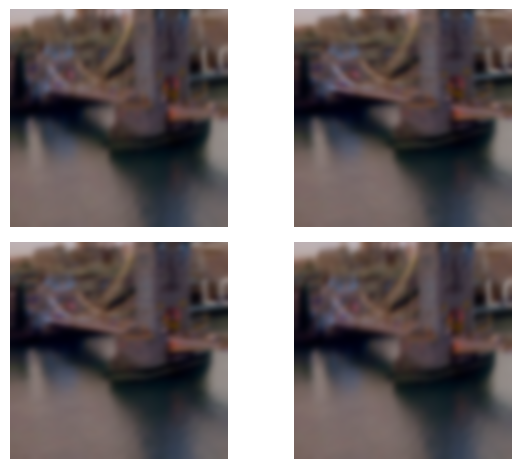

In [ ]:
plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(sorted_blurry[index + 100])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
save_images_to_folder(np.array(sorted_blurry[:10_000]), sorted_file_names, 'new_images')

In [ ]:
with strategy.scope():

    input = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # Encoder
    x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    # Autoencoder
    autoencoder = tf.keras.models.Model(input, x)
    optimizer = tf.keras.optimizers.Adam(1e-3)

    checkpoint_path = './london_small_auto'
    ckpt = tf.train.Checkpoint(transformer=autoencoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)


    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            ckpt_save_path = ckpt_manager.save()


    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    autoencoder.fit(x=blurred_images[:10_000], y=original_array[:10_000], batch_size=32, epochs=0, callbacks=[CustomCallback()])

In [ ]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units=128, activation='relu'):
        super(FeedForward, self).__init__()

        self.dense = tf.keras.layers.Dense(units)
        self.norm = tf.keras.layers.LayerNormalization()
        self.act = tf.keras.layers.Activation(activation)

    def call(self, inputs):
        outputs = self.dense(inputs)
        outputs = self.norm(outputs)
        outputs = self.act(outputs)

        return outputs


class SinusoidalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dims=128, embedding_min_frequency=1.0, embedding_max_frequency=1000.0):
        super(SinusoidalEmbedding, self).__init__()

        self.embedding_min_frequency = embedding_min_frequency
        self.embedding_max_frequency = embedding_max_frequency
        self.embedding_dims = embedding_dims

    def call(self, x):

        frequencies = tf.exp(
        tf.linspace(tf.math.log(self.embedding_min_frequency),
                    tf.math.log(self.embedding_max_frequency),
                    self.embedding_dims // 2))

        angular_speeds = 2.0 * math.pi * frequencies
        embeddings = tf.concat(
            [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)],
            axis=3)

        return embeddings


class Block(tf.keras.layers.Layer):
    def __init__(self, filters=128, kernel_size=3, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_1 = tf.keras.layers.Conv2D(filters, 1, padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='swish')
        self.conv_3 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')

        self.norm_1 = tf.keras.layers.BatchNormalization(center=False, scale=False)


    def call(self, x_img):

        x_r = self.conv_1(x_img)

        x_out = self.norm_1(x_img)
        x_out = self.conv_2(x_out)
        x_out = self.conv_3(x_out)
        x_out += x_r

        return x_out
    
    def get_config(self, **kwargs):
        config = super().get_config(**kwargs)
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
        })
        return config
 
        
class UNet(tf.keras.models.Model):

    def __init__(self, out_channels=3, image_size=32, depth=3, copy_rate=0.999, init_filter=256):
        super(UNet, self).__init__(name='unet')

        self.depth = depth
        self.init_filter = init_filter
        self.up_and_down_filters = [128, 128, 128]
        self.mid_filters = [128, 128]
        self.image_shape = (image_size, image_size, out_channels)
        self.copy_rate = copy_rate
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

        self.min_signal_rate = 0.02
        self.max_signal_rate = 0.95

        self.norm = tf.keras.layers.Normalization(mean=0, variance=1)
        self.norm_1 = tf.keras.layers.Normalization(mean=0, variance=1)

        self.norm_group = tf.keras.layers.GroupNormalization()
        self.activation = tf.keras.activations.swish

        self.training_model = self.model_n(self.image_shape)
        self.generation_model = self.model_n(self.image_shape)

        self.conv_layers = [tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same") for _ in range(4)] + [tf.keras.layers.Conv2D(3, kernel_size=1, padding="same")]
        self.num_channels = 3
        
    
    def model_n(self, image_shape,):

        image_with_noise = tf.keras.Input(shape=image_shape)
        x = tf.keras.layers.Conv2D(self.init_filter, kernel_size=1, padding="same")(image_with_noise)
 
        # down
        down_history = []
        for filter in self.up_and_down_filters:
            for _ in range(self.depth):
                x = Block(filter)(x)
                down_history.append(x)
            x = tf.keras.layers.MaxPool2D(2)(x)

        # mlp
        for filter in self.mid_filters:
            x = Block(filter)(x)

        # up
        for filter in reversed(self.up_and_down_filters):

            x = tf.keras.layers.UpSampling2D(2, interpolation="bilinear")(x)
            for _ in range(self.depth):
                x = tf.keras.layers.Concatenate()([x, down_history.pop()])
                x = Block(filter)(x)

        x = self.norm_group(x)
        x = self.activation(x)
        x = tf.keras.layers.Conv2D(image_shape[-1], kernel_size=1, padding="same", kernel_initializer="zeros")(x)

        return tf.keras.Model([image_with_noise], x)

    def call(self, inputs, training):
            
        if training:
            model_used = self.training_model
        else:
            model_used = self.generation_model

        pred_images = model_used([inputs], training=training)

        return pred_images

    def train_step(self, inputs):
        
        high_q, low_q = inputs
        
        high_q = self.norm_1(high_q)
        low_q = self.norm(low_q)

       
        with tf.GradientTape() as tape:
            
            generated_image = self([low_q], training=True)
            loss = self._compute_loss(high_q, generated_image)

        grads = tape.gradient(loss, self.training_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.training_model.trainable_weights))

        for weight, ema_weight in zip(self.training_model.weights, self.generation_model.weights):
            ema_weight.assign(self.copy_rate * ema_weight + (1 - self.copy_rate) * weight)
            
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, real_noise, pred_noise):

        loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        loss = loss_object(real_noise, pred_noise)
        loss = tf.reduce_sum(loss)
        return loss

        
with strategy.scope():
    train_set = tf.data.Dataset.from_tensor_slices((original_array[:10_000], blurred_images[:10_000]))
    train_set = train_set.batch(32, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)

    im_sh = original_array.shape
    model = UNet(out_channels=im_sh[-1], image_size=im_sh[-2])

    optimizer = tf.keras.optimizers.Adam(1e-5)

    checkpoint_path = './cnmjk_diffuse_london_small'
    ckpt = tf.train.Checkpoint(transformer=model, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

    # if a checkpoint exists, restore the latest checkpoint.
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print('Latest checkpoint restored!!')

    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            ckpt_save_path = ckpt_manager.save()
    # , callbacks=[CustomCallback()]


    model.compile(optimizer=optimizer)
    model.fit(train_set, epochs=600, callbacks=[CustomCallback()])

In [10]:
n = 2
test_images = np.array(blurred_images[:n])

pred_images = model.predict([test_images])
x = (pred_images - np.min(pred_images))/(np.max(pred_images) - np.min(pred_images))

ins = np.concatenate([blurred_images[:1], blurred_images[1:2], pred_images])

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(ins[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

1/1 [==============================] - 23s 23s/step


313/313 [==============================] - 168s 395ms/step


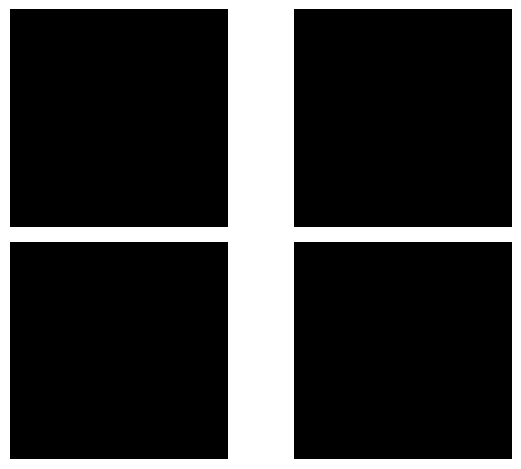

In [11]:
auto = False
with strategy.scope():

    if auto:
        pred_images = autoencoder.predict(np.array(sorted_blurry[:10_000]))
    
    else:
        pred_images = model.predict(tf.data.Dataset.from_tensor_slices(sorted_blurry[:10_000]).batch(32))
 
plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(np.concatenate([pred_images[1:3], sorted_blurry[1:3]])[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [12]:
save_images_to_folder(np.array(pred_images), sorted_file_names[:10_000], 'new_images')

Saved new_images/0.jpg
Saved new_images/1.jpg
Saved new_images/2.jpg
Saved new_images/3.jpg
Saved new_images/4.jpg
Saved new_images/5.jpg
Saved new_images/6.jpg
Saved new_images/7.jpg
Saved new_images/8.jpg
Saved new_images/9.jpg
Saved new_images/10.jpg
Saved new_images/11.jpg
Saved new_images/12.jpg
Saved new_images/13.jpg
Saved new_images/14.jpg
Saved new_images/15.jpg
Saved new_images/16.jpg
Saved new_images/17.jpg
Saved new_images/18.jpg
Saved new_images/19.jpg
Saved new_images/20.jpg
Saved new_images/21.jpg
Saved new_images/22.jpg
Saved new_images/23.jpg
Saved new_images/24.jpg
Saved new_images/25.jpg
Saved new_images/26.jpg
Saved new_images/27.jpg
Saved new_images/28.jpg
Saved new_images/29.jpg
Saved new_images/30.jpg
Saved new_images/31.jpg
Saved new_images/32.jpg
Saved new_images/33.jpg
Saved new_images/34.jpg
Saved new_images/35.jpg
Saved new_images/36.jpg
Saved new_images/37.jpg
Saved new_images/38.jpg
Saved new_images/39.jpg
Saved new_images/40.jpg
Saved new_images/41.jpg
Sa